## This notebook
- loads parquet files from `./outfiles0` and `./outfiles01`
- the former has candidate_fj defined as closest to the jet
- the latter has candidate_fj defined as closest to the jet but above dr>0.1 (cleaning)
- the sample is HWW semileptonic sample... 20 root files that were processed...

In [1]:
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from coffea import nanoevents
from coffea import processor
import time

import argparse
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
import pickle as pkl
import pandas as pd
import os
import sys
sys.path.append("../")

from collections import defaultdict
import pickle as pkl
import pyarrow as pa
import awkward as ak
import numpy as np
import pandas as pd
import json
import os
import shutil
import pathlib
from typing import List, Optional
import pyarrow.parquet as pq

from coffea import processor
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
from boostedhiggs.utils import match_HWW
from boostedhiggs.btag import btagWPs
from boostedhiggs.btag import BTagCorrector

import hist as hist2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import mplhep as hep
from hist.intervals import clopper_pearson_interval

import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
! ls test/

outfiles        outfiles_june20 outfiles_new


In [3]:
! ls test/outfiles_june20

0-1.pkl         0-1_ele.parquet 0-1_had.parquet 0-1_mu.parquet


In [4]:
with open("./test/outfiles_new/0-1.pkl", 'rb') as f:
    new = pkl.load(f)

data_new = pq.read_table("./test/outfiles_new/0-1_mu.parquet").to_pandas()

In [5]:
len(data_new)

0

In [6]:
with open("./test/outfiles_june20/0-1.pkl", 'rb') as f:
    june_20 = pkl.load(f)

    data_june_20 = pq.read_table("./test/outfiles_june20/0-1_mu.parquet").to_pandas()

In [7]:
len(data_june_20)

73

In [33]:
select = data_june_20['met']>-100000
data_june_20['met'][select]

0      33.491756
1     117.364410
2      84.576859
3      17.041643
4      35.143532
         ...    
68     31.051928
69     75.668480
70     90.090439
71     65.895943
72     65.714912
Name: met, Length: 73, dtype: float32

In [33]:
! ls test/outfiles

0-1.pkl         0-1_had.parquet 0-3.pkl         0-3_mu.parquet
0-1_ele.parquet 0-1_mu.parquet  0-3_ele.parquet 0-3had


In [82]:
with open("./test/outfiles/0-1.pkl", 'rb') as f:
    new2 = pkl.load(f)
    
data_new2 = pq.read_table("./test/outfiles/0-1_ele.parquet").to_pandas()

In [83]:
new2

{'GluGluHToWWToLNuQQ': {'2017': {'sumgenweight': 2842898.2,
   'cutflows': {'ele': {'metfilters': 5679,
     'oneLepton': 93,
     'fatjetKin': 200,
     'antibjettag': 188,
     'all': 98400,
     'notaus': 93,
     'leptonInJet': 94,
     'trigger': 5680,
     'ht': 200,
     'leptonKin': 93},
    'mu': {'metfilters': 10872,
     'oneLepton': 108,
     'fatjetKin': 296,
     'antibjettag': 276,
     'all': 98400,
     'notaus': 82,
     'leptonInJet': 108,
     'trigger': 10877,
     'ht': 296,
     'leptonKin': 108}}},
  'mc': 10}}

In [84]:
len(data_new2)

93

In [85]:
data_new2

,met,ht,nfj,deta,mjj,weight,weight_genweight,weight_L1Prefiring,weight_pileup,ele_highPtId,...,gen_Hpt,gen_Hnprongs,gen_iswlepton,gen_iswstarlepton,fj_ttbar_bmerged,fj_ttbar_bsplit,fj_wjets_label,fj_isHVV_elenuqq,fj_isHVV_munuqq,fj_isHVV_taunuqq
0,108.861389,643.296875,2,0.665524,127.691750,28.408458,28.893,1.000000,0.983230,True,...,326.0,2,True,False,0.009156,0.007215,0.302030,0.657752,0.000080,0.023767
1,76.918526,477.687500,2,1.405029,267.812866,30.420898,28.893,1.000000,1.052881,True,...,NaN,1,True,False,0.005980,0.014532,0.546833,0.409698,0.000142,0.022814
2,65.003716,526.718750,2,0.221264,87.730652,34.272704,28.893,1.000000,1.186194,True,...,281.0,2,True,False,0.004218,0.015122,0.595081,0.356463,0.000144,0.028971
3,77.466438,1172.937500,2,0.372559,122.723518,23.792788,28.893,0.861702,0.955643,True,...,401.0,3,False,True,0.002122,0.001072,0.018801,0.935241,0.000185,0.042578
4,19.559725,643.843750,2,1.928406,516.429688,19.663709,28.893,0.693622,0.981183,True,...,226.0,3,False,True,0.009805,0.046667,0.129569,0.698586,0.004250,0.111124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,64.786095,429.593750,2,0.194424,140.747681,33.959789,28.893,1.000000,1.175364,True,...,198.0,2,False,True,NaN,NaN,NaN,NaN,NaN,NaN
89,48.443806,487.062500,2,0.374756,57.211437,27.752251,28.893,1.000000,0.960518,True,...,237.0,3,True,False,NaN,NaN,NaN,NaN,NaN,NaN
90,255.621109,1083.062500,3,2.016113,811.485962,26.112992,28.893,0.984487,0.918024,True,...,540.0,3,True,False,NaN,NaN,NaN,NaN,NaN,NaN
91,126.429306,662.156250,1,1.602905,236.531769,28.079763,28.893,0.973684,0.998120,True,...,308.0,3,True,False,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
with open("./test/outfiles/0-3.pkl", 'rb') as f:
    new = pkl.load(f)

In [45]:
new_3files

{'GluGluHToWWToLNuQQ': {'mc': 30,
  '2017': {'cutflows': {'ele': {'leptonInJet': 243,
     'notaus': 3,
     'oneLepton': 3,
     'fatjetKin': 543,
     'metfilters': 16812,
     'ht': 543,
     'all': 295200,
     'antibjettag': 504,
     'trigger': 16816,
     'leptonKin': 3},
    'mu': {'leptonInJet': 243,
     'notaus': 3,
     'oneLepton': 3,
     'fatjetKin': 543,
     'metfilters': 16812,
     'ht': 543,
     'all': 295200,
     'antibjettag': 504,
     'trigger': 16816,
     'leptonKin': 3}},
   'sumgenweight': 8528405.0}}}

# Load metadata and parquet files

### candidate_fj: closest good_fatjet to the lepton

In [2]:
job_name = '/0-20'
channels=['ele', 'mu', 'had']
outfiles = "outfiles0"

with open("./" + outfiles + job_name + '.pkl', 'rb') as f:
    metadata0 = pkl.load(f)
    
for key in metadata0.keys():
    sample = key

data0 = {}
data0[sample] = {}

data0[sample]['ele'] = pq.read_table("./" + outfiles + job_name + '_' + 'ele' + '.parquet').to_pandas()

In [3]:
non_Null = data0[sample]['ele']['lep_fj_dr']>0
print(f"only {non_Null.sum()} out of {len(data0[sample]['ele'])} are non-Null")

data0[sample]['ele'] = data0[sample]['ele'][non_Null]
ev0 = len(data0[sample]['ele'])

only 3036 out of 10697 are non-Null


In [4]:
dr_01 = data0[sample]['ele']['lep_fj_dr']<=0.1
print(f"only {dr_01.sum()} out of {ev0} are within dr=0.1")

only 306 out of 3036 are within dr=0.1


### candidate_fj: closest good_fatjet to the lepton above dr>0.1

In [5]:
job_name = '/0-20'
channels=['ele', 'mu', 'had']
outfiles = "outfiles01"

with open("./" + outfiles + job_name + '.pkl', 'rb') as f:
    metadata01 = pkl.load(f)
    
for key in metadata0.keys():
    sample = key

data01 = {}
data01[sample] = {}

data01[sample]['ele'] = pq.read_table("./" + outfiles + job_name + '_' + 'ele' + '.parquet').to_pandas()

In [6]:
non_Null = data01[sample]['ele']['lep_fj_dr']>0
print(f"only {non_Null.sum()} out of {len(data01[sample]['ele'])} are non-Null")

data01[sample]['ele'] = data01[sample]['ele'][non_Null]
ev01 = len(data01[sample]['ele'])

only 2973 out of 10697 are non-Null


In [7]:
print(f"Comparing with no cut, we will drop: {round(100*((ev0-ev01)/ev0),2)} % of events")

Comparing with no cut, we will drop: 2.08 % of events


# Investigate the parquet files

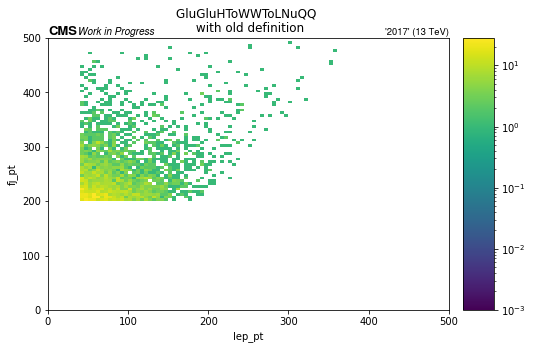

In [18]:
# lep_pt vs fj_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),    
    hist2.axis.Regular(100,0, 500, name='fj_pt', label='fj_pt', flow=True),
)

h.fill(data0[sample]['ele']['lep_pt'], data0[sample]['ele']['fj_pt']
)

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h, ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3)) 

ax.set_title(f'{sample} \n with old definition')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);

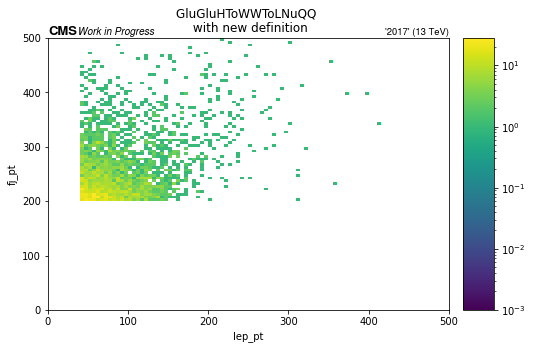

In [19]:
# lep_pt vs fj_pt
h = hist2.Hist(
    hist2.axis.Regular(100,0, 500, name='lep_pt', label='lep_pt', flow=True),    
    hist2.axis.Regular(100,0, 500, name='fj_pt', label='fj_pt', flow=True),
)

h.fill(data01[sample]['ele']['lep_pt'], data01[sample]['ele']['fj_pt']
)

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h, ax=ax, norm=matplotlib.colors.LogNorm(vmin=1e-3))    
ax.set_title(f'{sample} \n with new definition')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);

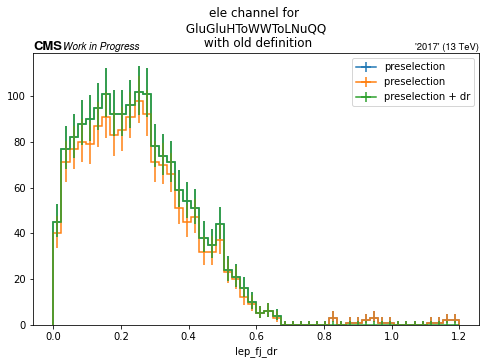

In [17]:
# distribution of dr
h = hist2.Hist(
    hist2.axis.Regular(50,0, 1.2, name='lep_fj_dr', label='lep_fj_dr', flow=True),    
    hist2.axis.StrCategory([], name='cut', growth=True)
)

h.fill(data0[sample]['ele']['lep_fj_dr'], 'preselection')
h.fill(data0[sample]['ele']['lep_fj_dr'][data0[sample]['ele']["anti_bjettag"] == 1], 'preselection + btag')
h.fill(data0[sample]['ele']['lep_fj_dr'][data0[sample]['ele']["leptonInJet"] == 1], 'preselection + dr')


fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot(h[{'cut': 'preselection'}], ax=ax, label = 'preselection')
hep.histplot(h[{'cut': 'preselection + btag'}], ax=ax, label = 'preselection ')
hep.histplot(h[{'cut': 'preselection + dr'}], ax=ax, label = 'preselection + dr')

ax.set_title(f'ele channel for \n {sample} \n with old definition')
ax.legend()
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);
plt.savefig('new.pdf')

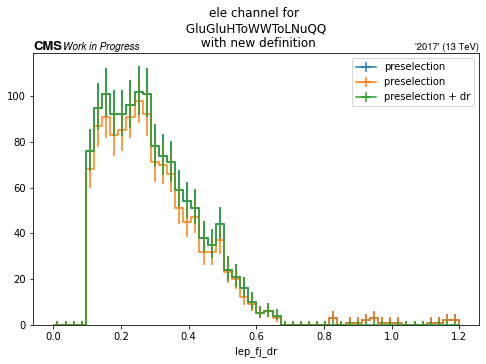

In [16]:
# distribution of dr
h = hist2.Hist(
    hist2.axis.Regular(50,0, 1.2, name='lep_fj_dr', label='lep_fj_dr', flow=True),    
    hist2.axis.StrCategory([], name='cut', growth=True),
    hist2.axis.StrCategory([], name='samples', growth=True)
    
)

h.fill(data01[sample]['ele']['lep_fj_dr'], 'preselection', 'lol')
h.fill(data01[sample]['ele']['lep_fj_dr'][data01[sample]['ele']["anti_bjettag"] == 1], 'preselection + btag', 'lol')
h.fill(data01[sample]['ele']['lep_fj_dr'][data01[sample]['ele']["leptonInJet"] == 1], 'preselection + dr', 'lol')


fig, ax = plt.subplots(figsize=(8, 5))
hep.histplot(h[{'cut': 'preselection', 'samples':'lol'}], ax=ax, label = 'preselection')
hep.histplot(h[{'cut': 'preselection + btag', 'samples':'lol'}], ax=ax, label = 'preselection ')
hep.histplot(h[{'cut': 'preselection + dr', 'samples':'lol'}], ax=ax, label = 'preselection + dr')

ax.set_title(f'ele channel for \n {sample} \n with new definition')
ax.legend()
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);
plt.savefig('new.pdf')

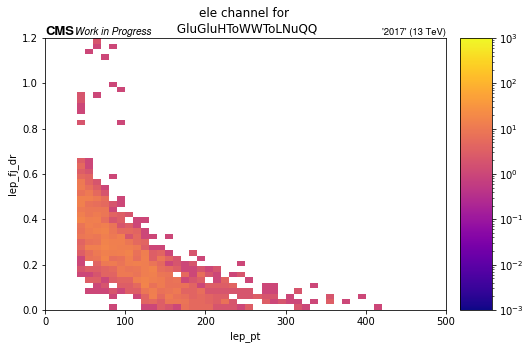

In [14]:
# distribution of dr
h = hist2.Hist(
    hist2.axis.Regular(50,0, 500, name='lep_pt', label='lep_pt', flow=True),        
    hist2.axis.Regular(50,0, 1.2, name='lep_fj_dr', label='lep_fj_dr', flow=True),    
)

h.fill(data0[sample]['ele']['lep_pt'], data0[sample]['ele']['lep_fj_dr'])

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h, ax=ax, cmap="plasma", norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1000))

ax.set_title(f'ele channel for \n {sample}')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);
# plt.savefig('new.pdf')

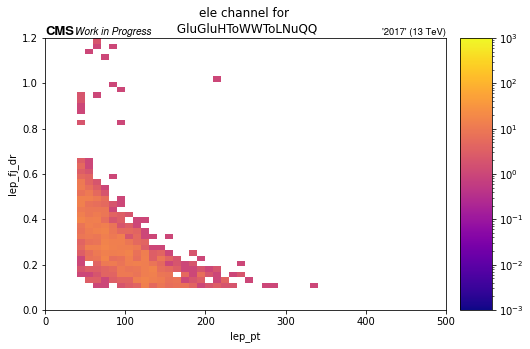

In [15]:
# distribution of dr
h = hist2.Hist(
    hist2.axis.Regular(50,0, 500, name='lep_pt', label='lep_pt', flow=True),        
    hist2.axis.Regular(50,0, 1.2, name='lep_fj_dr', label='lep_fj_dr', flow=True),    
)

h.fill(data01[sample]['ele']['lep_pt'], data01[sample]['ele']['lep_fj_dr'])

fig, ax = plt.subplots(figsize=(8, 5))
hep.hist2dplot(h, ax=ax, cmap="plasma", norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1000))

ax.set_title(f'ele channel for \n {sample}')
hep.cms.lumitext(f"'2017' (13 TeV)", ax=ax)
hep.cms.text("Work in Progress", ax=ax);
# plt.savefig('new.pdf')

### Investigating EGamma

In [12]:
data = pq.read_table('./19-34_ele.parquet').to_pandas()

In [13]:
data

""
